In [1]:
from math import exp
class myTensor:
    def __init__(self, data, _prev=None, _opr='', label=''):
        self.data = float(data)
        self.grad = 0
        self._backward = lambda: None
        self.label = label
        self._opr = _opr

        if _prev: # since set is a mutable object
            self._prev = set(_prev)
        else:
            self._prev = set()
            
    
    def __repr__(self):
        #return f"myTensor(data={self.data})"
        return f"{self.data}"
    
    def __add__(self, other):
        if type(other)!=myTensor:
            other=myTensor(other)
        out = myTensor(self.data+other.data, (self,other), '+', label=self.label+'+'+other.label if self.label!='' and other.label!='' else '')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __rmul__(self, other): # other*self
        return self*other
    
    def __radd__(self, other): # other*self
        return self + other
    

    def __truediv__(self, other):
        return self*other**-1
    
    def __pow__(self,n):
        assert isinstance(n,(int,float)), "only supports int/float powers"
        out = myTensor(self.data**n, (self,),f'**{n}')

        def _backward():
            self.grad += n*self.data**(n-1) * out.grad # TODO exercise : done!
        out._backward = _backward

        return out

    def __mul__(self, other):
        if type(other)!=myTensor:
            other=myTensor(other)
        out = myTensor(self.data*other.data, (self,other), '*', label=self.label+'*'+other.label if self.label!='' and other.label!='' else '')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.data
        s = 1/(1+exp(-x))
        out = myTensor(s, (self,), 'sigmoid', label=f'\u03C3({self.label})' if self.label!='' else '')
        def _backward():
            self.grad += (exp(-x)/((1+exp(-x))**2)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (exp(2*x)-1)/(exp(2*x)+1)
        out = myTensor(t, (self,), 'tanh', label=f'tanh({self.label})' if self.label!='' else '')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backprop(self,isRoot=True):
        if isRoot:
            self.grad = 1.0
        self._backward()
        for child in self._prev:
            child.backprop(isRoot=False)


b1=myTensor(1.0,label='b1')
x1=myTensor(5.0,label='x1')
w1=myTensor(-3.0,label='w1')

b2=myTensor(1.0,label='b2')
x2=myTensor(7.0,label='x2')
w2=myTensor(2.0,label='w2')

a=(w1*x1+b1)+(w2*x2+b2); a.label='a'
loss=a.tanh()
print(loss)

0.7615941559557649


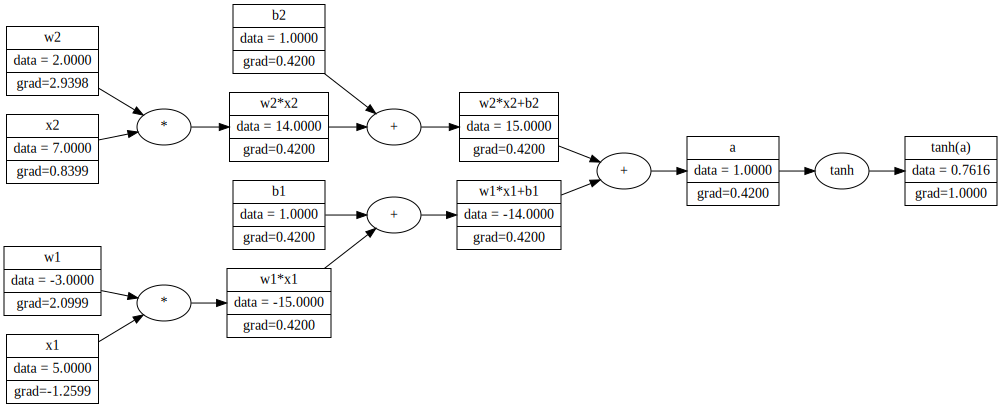

In [2]:
from graphviz import Digraph # this snippet is straight from Andrej's tutorial

def traceback(root):
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    #print(nodes,edges)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR will draw left to right
    nodes, edges= traceback(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label='{} | data = {:.4f} | grad={:.4f}'.format(n.label, n.data,n.grad), shape='record')
        if n._opr:
            dot.node(name=uid+n._opr, label=n._opr)
            dot.edge(uid+n._opr,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str((id(n2)))+n2._opr)
    return dot
loss.backprop()
draw_dot(loss)

Checking if using the custom backpropagation for myTensor class gives the correct grad values:

In [3]:
from torch import Tensor, sigmoid, tanh
t_b1 = Tensor([b1.data]).double(); t_b1.requires_grad=True
t_x1 = Tensor([x1.data]).double(); t_x1.requires_grad=True
t_w1 = Tensor([w1.data]).double(); t_w1.requires_grad=True

t_b2 = Tensor([b2.data]).double(); t_b2.requires_grad=True
t_x2 = Tensor([x2.data]).double(); t_x2.requires_grad=True
t_w2 = Tensor([w2.data]).double(); t_w2.requires_grad=True

t_a=(t_w1*t_x1+t_b1)+(t_w2*t_x2+t_b2)

t_loss=tanh(t_a)
t_loss.backward()

print('b1: value =', t_b1.data.item(),' torch_grad =',t_b1.grad.item(),' my_grad =', b1.grad)
print('x1: value =', t_x1.data.item(),' torch_grad =',t_x1.grad.item(),' my_grad =', x1.grad)
print('w1: value =', t_w1.data.item(),' torch_grad =',t_w1.grad.item(),' my_grad =', w1.grad)
print('b2: value =', t_b2.data.item(),' torch_grad =',t_b2.grad.item(),' my_grad =', b2.grad)
print('x2: value =', t_x2.data.item(),' torch_grad =',t_x2.grad.item(),' my_grad =', x2.grad)
print('w2: value =', t_w2.data.item(),' torch_grad =',t_w2.grad.item(),' my_grad =', w2.grad)


b1: value = 1.0  torch_grad = 0.41997434161402614  my_grad = 0.41997434161402614
x1: value = 5.0  torch_grad = -1.2599230248420783  my_grad = -1.2599230248420783
w1: value = -3.0  torch_grad = 2.099871708070131  my_grad = 2.099871708070131
b2: value = 1.0  torch_grad = 0.41997434161402614  my_grad = 0.41997434161402614
x2: value = 7.0  torch_grad = 0.8399486832280523  my_grad = 0.8399486832280523
w2: value = 2.0  torch_grad = 2.939820391298183  my_grad = 2.939820391298183


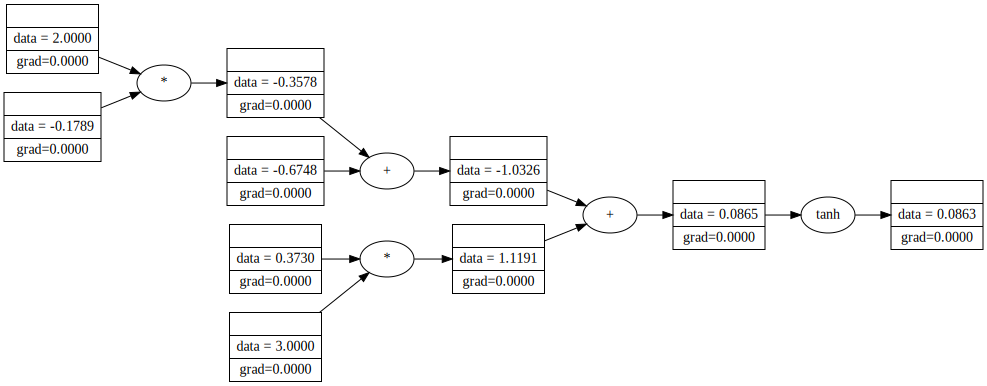

In [4]:
import random

class myNeuron:
    def __init__(self, nin):
        self.w = [myTensor(random.uniform(-1,1)) for _ in range(nin)]
        self.b = myTensor(random.uniform(-1,1))
    def __call__(self,x, act='tanh'):
        a = sum([wi*xi for wi,xi in zip(self.w,x)], self.b)
        if act == 'tanh':
            out = a.tanh()
        else:
            out = a.sigmoid()
        return out
    def parameters(self):
        #print(self.w,self.b)
        return self.w+[self.b]

class myLayer:
    def __init__(self, nin, nout):
        self.neurons = [myNeuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class myMPL:
    def __init__(self, ns):
        self.layers = [myLayer(ns[i],ns[i+1]) for i in range(len(ns)-1)]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x=[2,3,-1]
mpl=myMPL([2,1])

draw_dot(mpl(x))

In [5]:
xs = [[2.0,3.0],
      [3.0,-1.0],
      [0.5,1.0]]
ys = [1,-1,-1]

In [6]:
epochs=10000
lr=0.01
for i in range(epochs+1): # TODO: custom optimizers like Adam, Adagrad, etc
    # foward pass
    ypreds = [mpl(x) for x in xs]
    train_loss=sum((y-ypred)**2 for y, ypred in zip(ys,ypreds))/len(ys); train_loss.label='train_loss' # MSE loss 

    # backward pass
    for p in mpl.parameters():
        p.grad=0
    train_loss.backprop()

    # update
    for p in mpl.parameters():
        p.data += - lr * p.grad
    if i % 500==0:
        print('step =', i,' train_loss =', train_loss.data)


step = 0  train_loss = 0.4117331955618936
step = 500  train_loss = 0.06788520200858872
step = 1000  train_loss = 0.03451883013266086
step = 1500  train_loss = 0.022554077318640627
step = 2000  train_loss = 0.016576788603548474
step = 2500  train_loss = 0.013035404838160038
step = 3000  train_loss = 0.010707904047230371
step = 3500  train_loss = 0.00906780556778042
step = 4000  train_loss = 0.007852833827930814
step = 4500  train_loss = 0.006918299155979098
step = 5000  train_loss = 0.006178097841976088
step = 5500  train_loss = 0.005577899730024984
step = 6000  train_loss = 0.005081785886215229
step = 6500  train_loss = 0.004665088174042248
step = 7000  train_loss = 0.004310320427105665
step = 7500  train_loss = 0.004004751600108402
step = 8000  train_loss = 0.003738898104969557
step = 8500  train_loss = 0.0035055540819531406
step = 9000  train_loss = 0.0032991486880335715
step = 9500  train_loss = 0.0031153088391985156
step = 10000  train_loss = 0.002950554805593658


Great! It overfitted like a champ! Which means it can correctly perform gradient descent.